# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Q1a
Splitting train and test from 2020

In [6]:
train_dataframe = df[df['year'] <= 2020] 
val_dataframe = df[df['year'] > 2020] 

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

### Why is this done instead of using random train/test splits?

Historic data on HDB has a relationship with its future prices, and by splitting data before 2020, it can better model a relationship between prices and other features, as well as predict more accurate results than data points picked randomly.

# Q1b

categorical data(integer): month<br>
categorical data(string): flat_model_type, storey_range<br>
continuous numerical data: dist_to_nearest_stn, dist_to_dhoby, degree_centrality, eigenvector_centrality, remaining_lease_years, floor_area_sqm

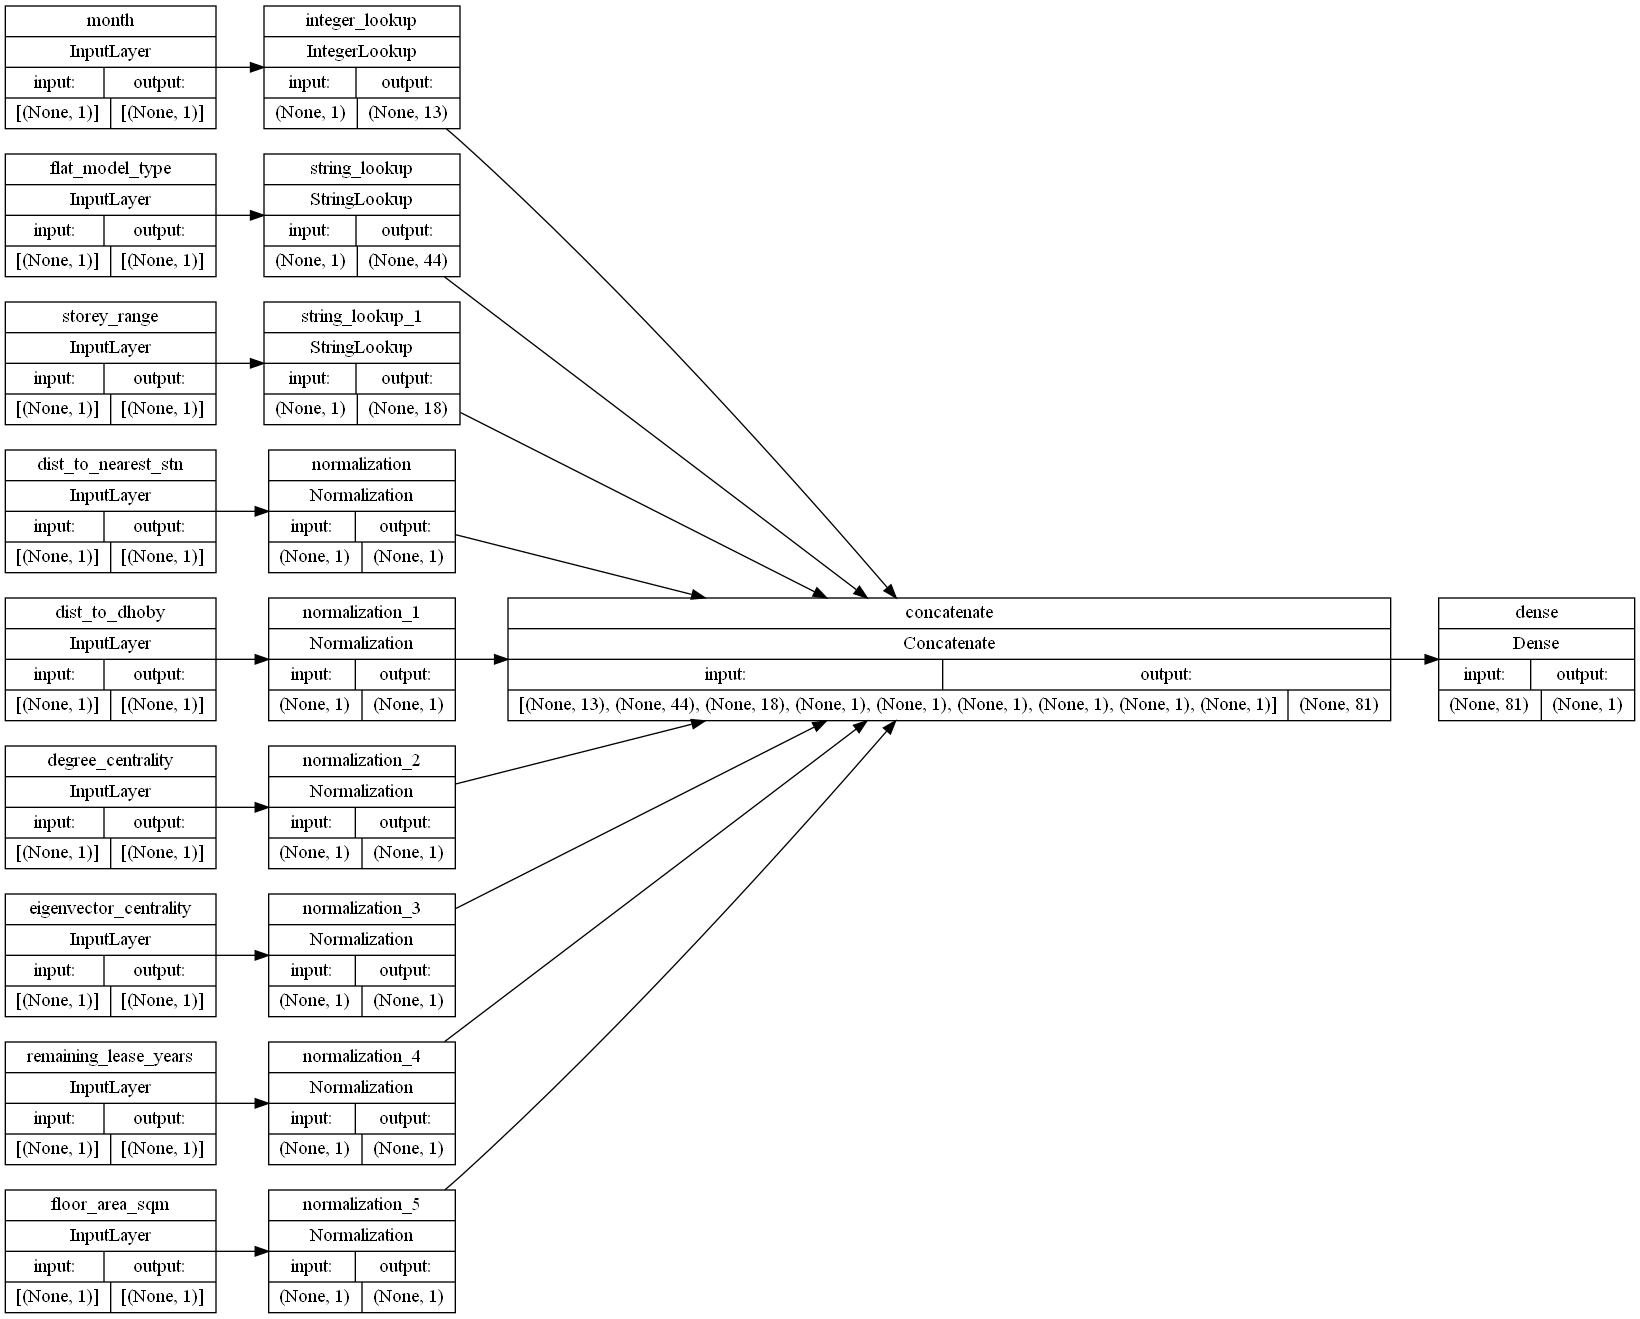

In [7]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

# Integer categorical features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded
    ]
)

output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Q1c

In [8]:
# adam optimizer

output = layers.Dense(1, activation="linear")(all_features)

adamOptimizer = tf.keras.optimizers.Adam(0.001)

model = keras.Model(all_inputs, output)
model.compile(optimizer=adamOptimizer,
              loss='mean_squared_error',
              metrics=[r2])

adam_optimizer = model.fit(train_ds, 
                          epochs=50,
                          batch_size=256,
                          validation_data=val_ds,
                          verbose = 'auto')

adam_score = model.evaluate(val_ds, verbose = 'auto')

Epoch 1/50


C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 3s 5ms/step - loss: 219585773568.0000 - r2: -8.3474 - val_loss: 301486505984.0000 - val_r2: -10.0832
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: 219584397312.0000 - r2: -8.3520 - val_loss: 301484867584.0000 - val_r2: -10.0722
Epoch 3/50
342/342 [==============================] - 2s 5ms/step - loss: 219583070208.0000 - r2: -8.3501 - val_loss: 301483294720.0000 - val_r2: -10.1026
Epoch 4/50
342/342 [==============================] - 2s 5ms/step - loss: 219581759488.0000 - r2: -8.3437 - val_loss: 301481754624.0000 - val_r2: -10.0800
Epoch 5/50
342/342 [==============================] - 2s 5ms/step - loss: 219580481536.0000 - r2: -8.3458 - val_loss: 301480181760.0000 - val_r2: -10.1214
Epoch 6/50
342/342 [==============================] - 2s 5ms/step - loss: 219579252736.0000 - r2: -8.3513 - val_loss: 301478674432.0000 - val_r2: -10.0838
Epoch 7/50
342/342 [==============================] - 2s 5ms/step - loss: 2195778

In [9]:
# SGD optimizer

output = layers.Dense(1, activation="linear")(all_features)

SGDOptimizer = keras.optimizers.SGD(learning_rate=0.01)

model = keras.Model(all_inputs, output)
model.compile(optimizer=SGDOptimizer,
              loss='mean_squared_error',
              metrics=[r2])

SGD_Optimizer = model.fit(train_ds, 
                          epochs=50,
                          batch_size=256,
                          validation_data=val_ds,
                          verbose = 'auto')

SGD_score = model.evaluate(val_ds, verbose = 'auto')

Epoch 1/50
342/342 [==============================] - 3s 5ms/step - loss: 18728699904.0000 - r2: 0.1966 - val_loss: 13789996032.0000 - val_r2: 0.4959
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: 5481927168.0000 - r2: 0.7678 - val_loss: 12796295168.0000 - val_r2: 0.5330
Epoch 3/50
342/342 [==============================] - 2s 5ms/step - loss: 5026648576.0000 - r2: 0.7875 - val_loss: 12325084160.0000 - val_r2: 0.5493
Epoch 4/50
342/342 [==============================] - 2s 5ms/step - loss: 4776963072.0000 - r2: 0.7976 - val_loss: 12102074368.0000 - val_r2: 0.5578
Epoch 5/50
342/342 [==============================] - 2s 5ms/step - loss: 4609033216.0000 - r2: 0.8049 - val_loss: 11926616064.0000 - val_r2: 0.5641
Epoch 6/50
342/342 [==============================] - 2s 4ms/step - loss: 4482668544.0000 - r2: 0.8106 - val_loss: 11662403584.0000 - val_r2: 0.5745
Epoch 7/50
342/342 [==============================] - 2s 4ms/step - loss: 4384753664.0000 - r2: 0.8140 - 

In [10]:
print("Adam vs SGD r^2 score\nAdam: {}, SGD: {}".format(adam_score[1], SGD_score[1]))

Adam vs SGD r^2 score
Adam: -10.08871841430664, SGD: 0.6095799803733826


In SGD optimizer a few samples is being picked up or we can say a few samples being get selected in a random manner instead taking up the whole dataset for each iteration.

In addition to storing an exponentially decaying average of past squared gradients, Adam also keeps an exponentially decaying average of past gradients similar to momentum. This causes the gradient to descent at an exponentially slowing rate, explaining the faster initial progress on the training loss yet plateauing performance quickly on the test error.

This therefore means the SGD can generalise better than adam, despite it taking a longer time.

# Q1d

In [11]:
x = layers.Dense(1, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

adamOptimizer = tf.keras.optimizers.Adam(0.08)

model = keras.Model(all_inputs, output)
model.compile(optimizer=adamOptimizer,
              loss='mean_squared_error',
              metrics=[r2])

adam_optimizer = model.fit(train_ds, 
                          epochs=50,
                          batch_size=256,
                          validation_data=val_ds,
                          verbose = 'auto')

adam_score_2 = model.evaluate(val_ds, verbose = 'auto')

Epoch 1/50
342/342 [==============================] - 3s 5ms/step - loss: 217533218816.0000 - r2: -8.2607 - val_loss: 293409325056.0000 - val_r2: -9.7684
Epoch 2/50
342/342 [==============================] - 2s 5ms/step - loss: 203579408384.0000 - r2: -7.6666 - val_loss: 269112901632.0000 - val_r2: -8.8781
Epoch 3/50
342/342 [==============================] - 2s 5ms/step - loss: 178412503040.0000 - r2: -6.5879 - val_loss: 233983639552.0000 - val_r2: -7.5904
Epoch 4/50
342/342 [==============================] - 2s 5ms/step - loss: 146543853568.0000 - r2: -5.2338 - val_loss: 192530972672.0000 - val_r2: -6.0669
Epoch 5/50
342/342 [==============================] - 2s 5ms/step - loss: 112042639360.0000 - r2: -3.7589 - val_loss: 149773107200.0000 - val_r2: -4.4912
Epoch 6/50
342/342 [==============================] - 2s 5ms/step - loss: 79437946880.0000 - r2: -2.3768 - val_loss: 110523301888.0000 - val_r2: -3.0575
Epoch 7/50
342/342 [==============================] - 2s 5ms/step - loss: 522

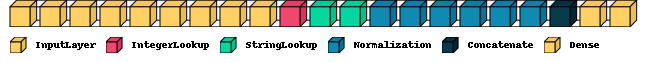

In [12]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True) 

In [13]:
print("Adam with 0.08 LR r^2 score\nAdam: {}".format(adam_score_2[1]))

Adam with 0.08 LR r^2 score
Adam: 0.6178855299949646


# Q1e

In [14]:
print("Adam r^2 score with 0.08 LR: {}\nSGD r^2 score with 0.01 LR: {}".format(adam_score[1], SGD_score[1]))

Adam r^2 score with 0.08 LR: -10.08871841430664
SGD r^2 score with 0.01 LR: 0.6095799803733826


The adam optimizer with 0.01 learning rate has a closer r^2 score to 1, indicating it perfored a better, as compared to the SGD.<br>
The adam optimizer should perform better than the SGD with a higher learning rate because the adam can reach global minimum faster than the SGD.

# Q2

In [15]:
# Split data, 2020 becomes val_data, upper years become test

train_dataframe_q2 = df[df['year'] < 2020]
val_dataframe_q2 = df[df['year'] == 2020]
test_dataframe_q2 = df[df['year'] > 2020]

train_ds_q2 = dataframe_to_dataset(train_dataframe_q2)
val_ds_q2 = dataframe_to_dataset(val_dataframe_q2)
test_ds_q2 = dataframe_to_dataset(test_dataframe_q2)

train_ds_q2 = train_ds_q2.batch(256)
val_ds_q2 = val_ds_q2.batch(256)

test_dataframe_q2

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
87370,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,07 TO 09,225000.0
87371,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,01 TO 03,211000.0
87372,1,2021,216 ANG MO KIO AVENUE 1,Ang Mo Kio,0.994153,7.427003,0.016807,0.006243,"3 ROOM, New Generation",54.333333,73.0,04 TO 06,275888.0
87373,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.083333,67.0,07 TO 09,316800.0
87374,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.000000,67.0,10 TO 12,305000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


# Q2b
The first argument is the number of distinct words in the training set. The second argument indicates the size of the embedding vectors. The input_length argument, of course, determines the size of each input sequence.

In [16]:
def embed_categorical_feature(feature, name, dataset, is_string, divisor=1):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    num_categories = lookup.vocabulary_size()
    embedded_feature = tf.keras.layers.Embedding(input_dim = num_categories, output_dim = math.floor(num_categories//divisor) )

    embedded_feature = embedded_feature(feature)
    embedded_feature = layers.Flatten()(embedded_feature)

    return embedded_feature

In [17]:
import math 

# Integer categorical features
month_embed = embed_categorical_feature(month, "month", train_ds_q2, False, 2)

# String categorical features
flat_model_type_embed = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds_q2, True, 2)
storey_range_embed = embed_categorical_feature(storey_range, "storey_range", train_ds_q2, True, 2)

# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds_q2)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds_q2)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds_q2)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds_q2)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds_q2)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds_q2)

all_features = layers.concatenate(
    [
        month_embed,
        flat_model_type_embed,
        storey_range_embed,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

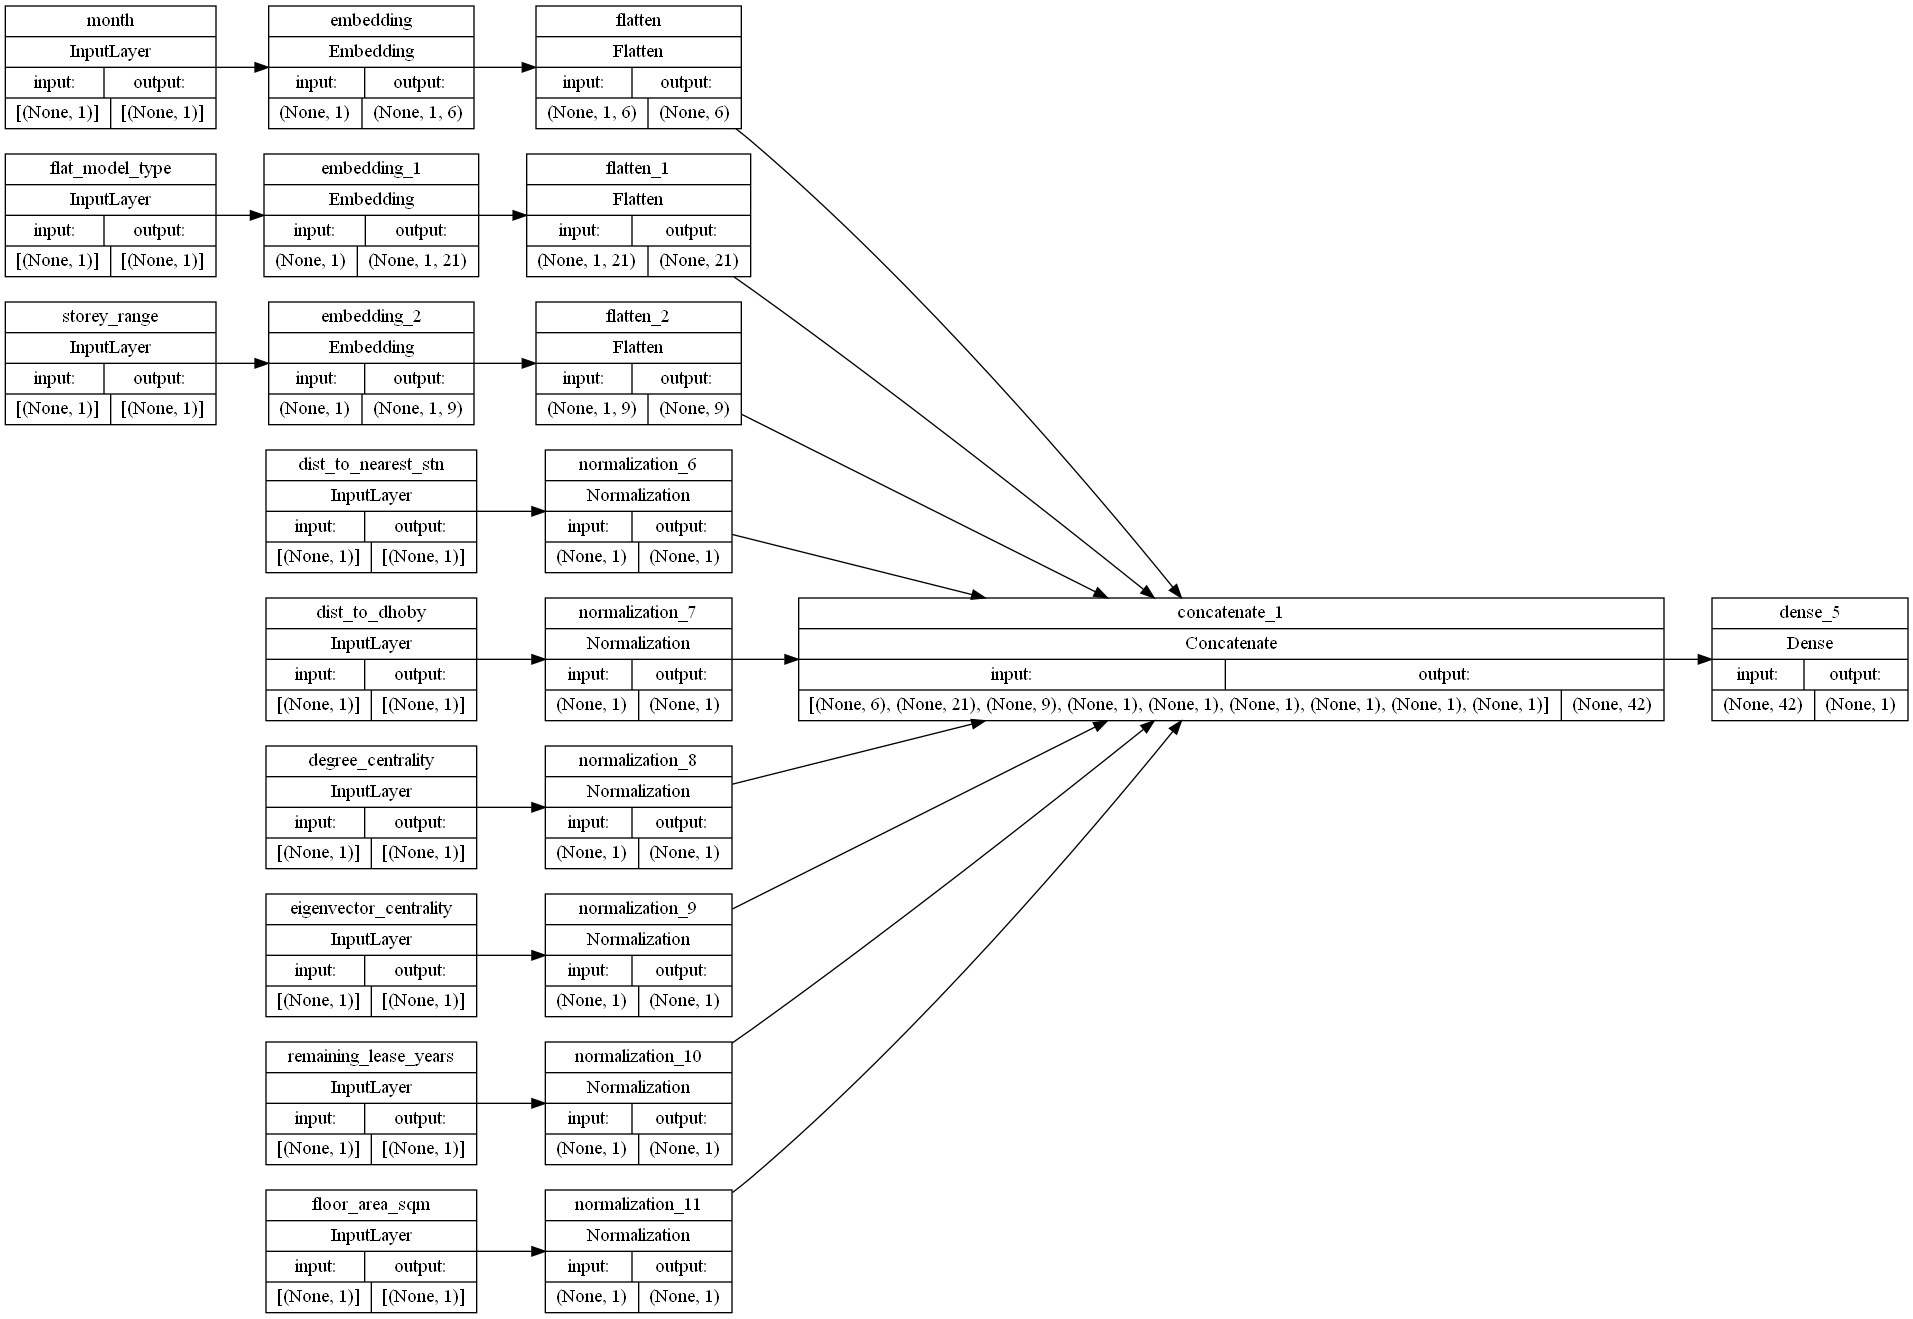

In [18]:
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [19]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 flat_model_type (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 storey_range (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 6)         78          ['month[0][0]']                  
                                                                                            

# Q2c

In [20]:
def embed_categorical_feature_tuning(feature, name, dataset, is_string, num_categories, hp):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)
    
    # divisor to be tuned 
    divisor = hp.Int('divisor', min_value=1, max_value=2, step=1)

    encoded_lookup = lookup(feature)
    # Turn the string input into integer indices
    encoded_feature = keras.layers.Embedding(input_dim = (num_categories+1), 
                                             output_dim = math.floor(num_categories/divisor))(encoded_lookup)
    encoded_feature = keras.layers.Flatten()(encoded_feature)
    
    return encoded_feature

In [21]:
import kerastuner as kt



# define the model
def model_builder(hp):
    # Categorical features encoded as integers
    month_len = len(np.unique(train_dataframe_q2['month']))
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    month_embedded = embed_categorical_feature_tuning(month, "month", train_ds_q2, False, month_len, hp)

    # Categorical feature encoded as string
    flat_model_type_len = len(np.unique(train_dataframe_q2['flat_model_type']))
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    flat_model_type_embedded = embed_categorical_feature_tuning(flat_model_type, "flat_model_type", train_ds_q2, True, flat_model_type_len, hp)

    storey_range_len = len(np.unique(train_dataframe_q2['storey_range']))
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
    storey_range_embedded = embed_categorical_feature_tuning(storey_range, "storey_range", train_ds_q2, True, storey_range_len, hp)

    # Numerical features
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds_q2)

    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds_q2)

    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds_q2) 

    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds_q2)

    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds_q2)

    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds_q2)

    all_inputs = [
      dist_to_nearest_stn,
      dist_to_dhoby,
      degree_centrality,
      eigenvector_centrality,
      remaining_lease_years,
      floor_area_sqm,
      month,
      flat_model_type,
      storey_range
    ]

    all_features = layers.concatenate(
      [
          month_embedded,
          flat_model_type_embedded,
          floor_area_sqm_encoded,
          storey_range_embedded,
          remaining_lease_years_encoded,
          eigenvector_centrality_encoded,
          degree_centrality_encoded,
          dist_to_dhoby_encoded,
          dist_to_nearest_stn_encoded        
      ]
    )



    # define the model
    x = layers.Dense(hp.Int('neuron_no', min_value=4, max_value=32, step=4), 
                   activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)

    model = keras.Model(all_inputs, output)

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log')),
                loss='mse', 
                metrics=[r2])

    return model

C:\Users\umer2\AppData\Local\Temp/ipykernel_27336/2053086261.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [22]:
tuner = kt.RandomSearch(model_builder,
                        objective='val_loss',
                        max_trials=10)



INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [23]:
tuner.search(train_ds_q2,
             epochs=50,
             validation_data=val_ds_q2,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

INFO:tensorflow:Oracle triggered exit


In [24]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best set of hyper parameters\nNodes: {}\nDivisor: {}\nLearning_rate: {}".format(best_hps.get('neuron_no'),best_hps.get('divisor'), best_hps.get('learning_rate')))

Best set of hyper parameters
Nodes: 16
Divisor: 2
Learning_rate: 0.03622532209052661


# Q2d

In [25]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds_q2, 
                    validation_data=val_ds_q2,
                    epochs=50,
                    batch_size=256)

Epoch 1/50


C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


251/251 [==============================] - 2s 5ms/step - loss: 121511550976.0000 - r2: -4.2068 - val_loss: 16055165952.0000 - val_r2: 0.3266 - loss: 121602465792.0000 - r2: -4.22
Epoch 2/50
251/251 [==============================] - 1s 4ms/step - loss: 11773808640.0000 - r2: 0.5019 - val_loss: 9886118912.0000 - val_r2: 0.5859
Epoch 3/50
251/251 [==============================] - 1s 4ms/step - loss: 9081926656.0000 - r2: 0.6147 - val_loss: 8868250624.0000 - val_r2: 0.6290
Epoch 4/50
251/251 [==============================] - 1s 4ms/step - loss: 8237916672.0000 - r2: 0.6498 - val_loss: 8280935424.0000 - val_r2: 0.6541
Epoch 5/50
251/251 [==============================] - 1s 4ms/step - loss: 7773710848.0000 - r2: 0.6694 - val_loss: 7927418368.0000 - val_r2: 0.6666
Epoch 6/50
251/251 [==============================] - 1s 4ms/step - loss: 7433618432.0000 - r2: 0.6827 - val_loss: 7571428864.0000 - val_r2: 0.6788
Epoch 7/50
251/251 [==============================] - 1s 4ms/step - loss: 715120

Text(0.5, 0, 'Epoch')

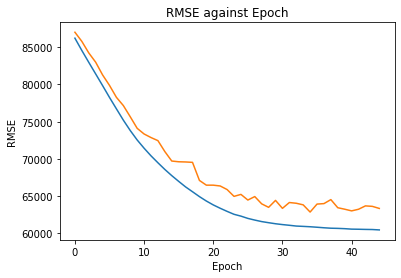

In [27]:
import matplotlib.pyplot as plt

rmse_train = np.sqrt(history.history['loss'])[5:]
rmse_test = np.sqrt(history.history['val_loss'])[5:]
plt.plot(rmse_train)
plt.plot(rmse_test)
plt.title('RMSE against Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')

# Q2e

In [28]:
test_results = model.predict(test_ds_q2.batch(256))
"""
arr = np.array(test_results)
test_results = np.argsort(arr)
top_30_worst = arr[-30 : ]
"""
top_30_worst_df = test_dataframe_q2.copy(deep=True)

top_30_worst_df['prediction'] = test_results
top_30_worst_df['error'] = abs(top_30_worst_df['prediction'] - top_30_worst_df['resale_price'])
top_30_worst_df = top_30_worst_df.sort_values('error', ascending=False)
top_30_worst_df.head(30)

C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,prediction,error
118295,7,2022,222 BISHAN STREET 23,Bishan,0.786740,6.514619,0.033613,0.015854,"EXECUTIVE, Maisonette",69.083333,146.0,10 TO 12,1238000.00,165406.734375,1.072593e+06
119400,5,2022,96A HENDERSON ROAD,Tiong Bahru,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,46 TO 48,1380000.00,328608.781250,1.051391e+06
131020,8,2022,139B LORONG 1A TOA PAYOH,Caldecott,0.484327,4.156703,0.016807,0.023913,"5 ROOM, DBSS",88.750000,114.0,31 TO 33,1265000.00,229622.109375,1.035378e+06
118249,6,2022,273B BISHAN STREET 24,Bishan,0.776182,6.297489,0.033613,0.015854,"5 ROOM, DBSS",88.250000,120.0,25 TO 27,1270000.00,236799.921875,1.033200e+06
114531,12,2021,1B CANTONMENT ROAD,Outram Park,0.352779,2.413099,0.033613,0.121082,"5 ROOM, Type S2",88.083333,107.0,40 TO 42,1288000.00,262647.125000,1.025353e+06
119399,5,2022,96A HENDERSON ROAD,Tiong Bahru,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,40 TO 42,1400000.00,397678.656250,1.002321e+06
124837,6,2022,7 BOON KENG ROAD,Boon Keng,0.365392,2.638175,0.016807,0.053004,"5 ROOM, DBSS",87.666667,117.0,28 TO 30,1288888.00,294502.281250,9.943857e+05
120285,2,2022,1B CANTONMENT ROAD,Outram Park,0.352779,2.413099,0.033613,0.121082,"5 ROOM, Type S2",87.916667,107.0,46 TO 48,1308000.00,313948.093750,9.940519e+05
116087,12,2021,139A LORONG 1A TOA PAYOH,Caldecott,0.514517,4.107963,0.016807,0.023913,"5 ROOM, DBSS",89.416667,117.0,34 TO 36,1220000.00,227065.765625,9.929342e+05
100263,6,2021,150 MEI LING STREET,Queenstown,0.245207,4.709043,0.016807,0.008342,"EXECUTIVE, Apartment",73.416667,148.0,10 TO 12,1235000.00,243777.796875,9.912222e+05


# Q3a

In [29]:
df_old = pd.read_csv('hdb_price_prediction_old.csv')
df_new_21 = df[df['year'] == 2021]
df_new_22 = df[df['year'] == 2022]

df_old_set = dataframe_to_dataset(df_old)
df_new_21_set = dataframe_to_dataset(df_new_21)
df_new_22_set = dataframe_to_dataset(df_new_22)

df_old_set = df_old_set.batch(256)
df_new_21_set = df_new_21_set.batch(256)
df_new_22_set = df_new_22_set.batch(256)
df_old

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [30]:
df_old_result = model.evaluate(df_old_set)
df_new_21_result = model.evaluate(df_new_21_set)
df_new_22_result = model.evaluate(df_new_22_set)

print("R^2 Error (old): " + str(df_old_result[1]))
print("R^2 Error (new 2021): " + str(df_new_21_result[1]))
print("R^2 Error (new 2022): " + str(df_new_22_result[1]))

67/67 [==============================] - 0s 2ms/step - loss: 15747525632.0000 - r2: 0.4457
R^2 Error (old): 0.828315258026123
R^2 Error (new 2021): 0.6940689086914062
R^2 Error (new 2022): 0.44568294286727905


# Q3b
Teams r^2 value in 1b: 0.627<br>
Teams r^2 value in Q3b: 0.76,             , 0.715             , 0.464<br>
My r^2 value in Q3a:    0.8281159400939941, 0.6888219118118286, 0.43993696570396423

Model degradation can be seen to affect the results of the model significantly, especially since the model is predicting on more recent data. This meant the model did not account for recent changes, a phenomenon called conceptual drift, which causes a statistical drift in prediction that the model never once took into account before.

# Q3c 

Covariate shift refers to the change in the distribution of the input variables present in the training and the test data

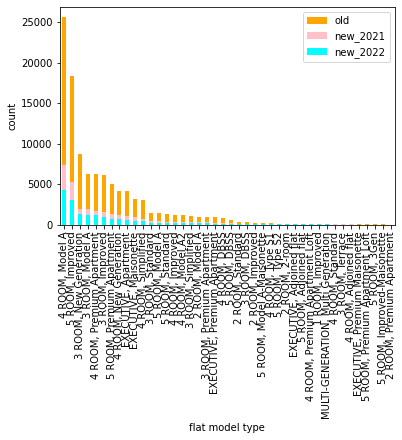

In [31]:
# flat model type feature

df_old["flat_model_type"].value_counts().plot.bar(color="orange")
df_new_21["flat_model_type"].value_counts().plot.bar(color="pink")
df_new_22["flat_model_type"].value_counts().plot.bar(color="cyan")

plt.legend(["old", "new_2021", "new_2022"])
plt.xlabel("flat model type")
plt.ylabel("count")

plt.rcParams["figure.figsize"] = (30,15)
plt.show()

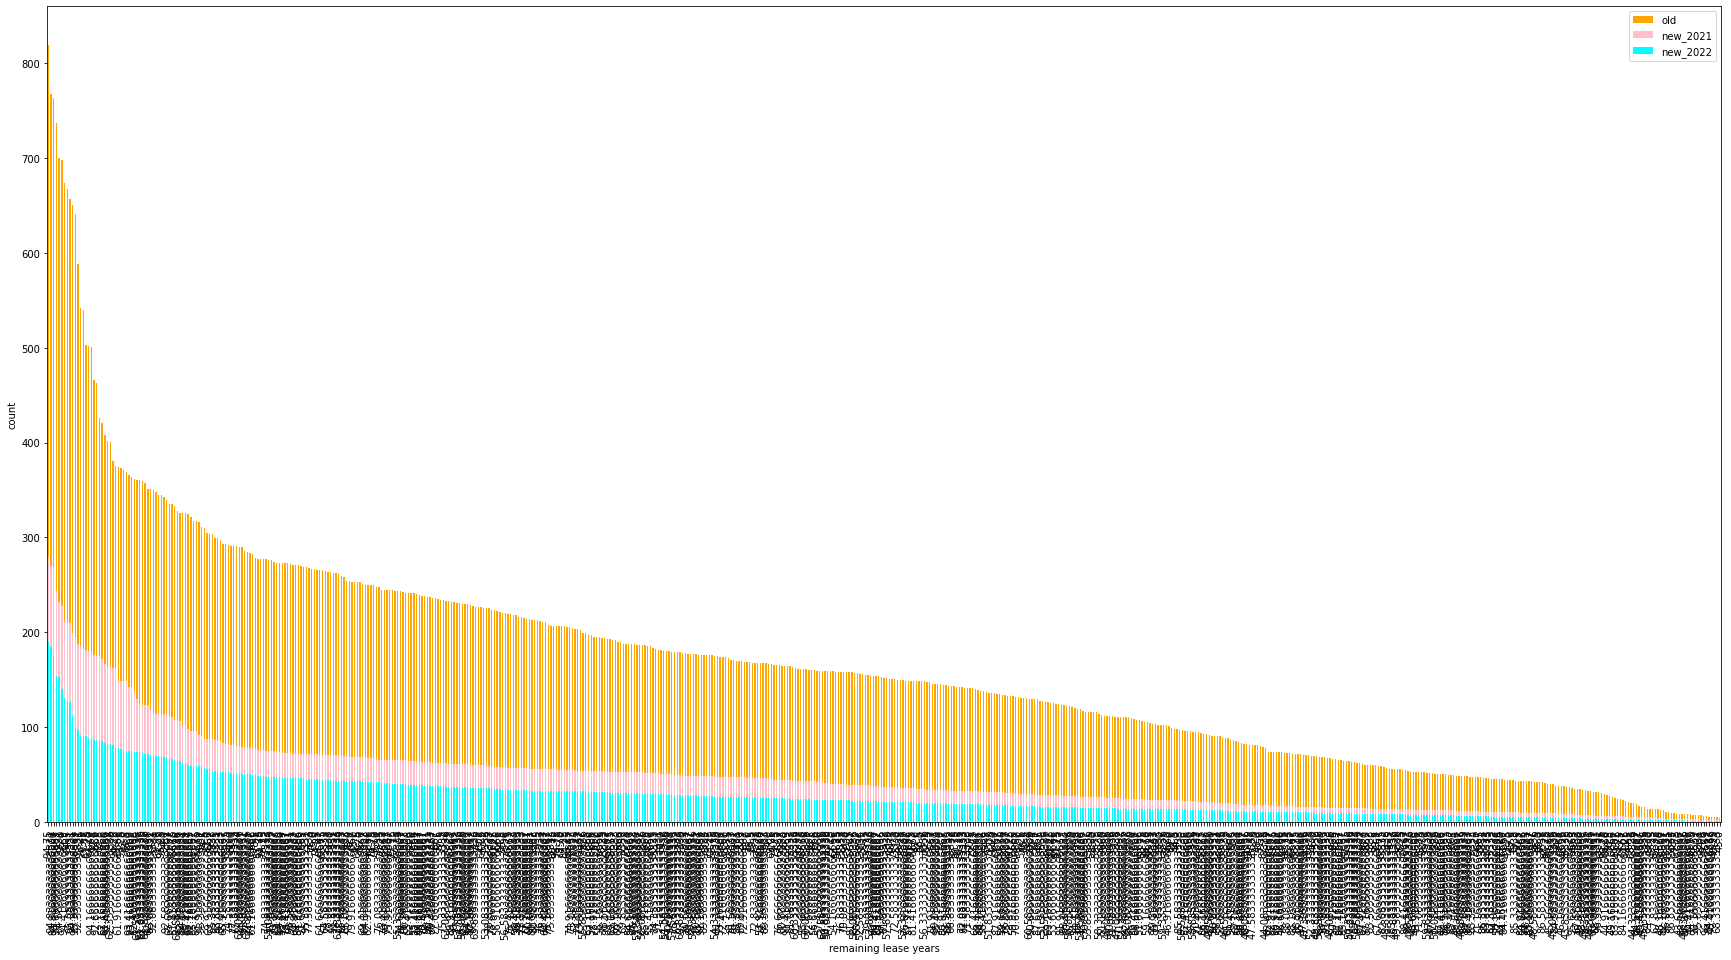

In [32]:
# remaining lease years feature

df_old["remaining_lease_years"].value_counts().plot.bar(color="orange")
df_new_21["remaining_lease_years"].value_counts().plot.bar(color="pink")
df_new_22["remaining_lease_years"].value_counts().plot.bar(color="cyan")

plt.legend(["old", "new_2021", "new_2022"])
plt.xlabel("remaining lease years")
plt.ylabel("count")

plt.rcParams["figure.figsize"] = (50,50)
plt.show()

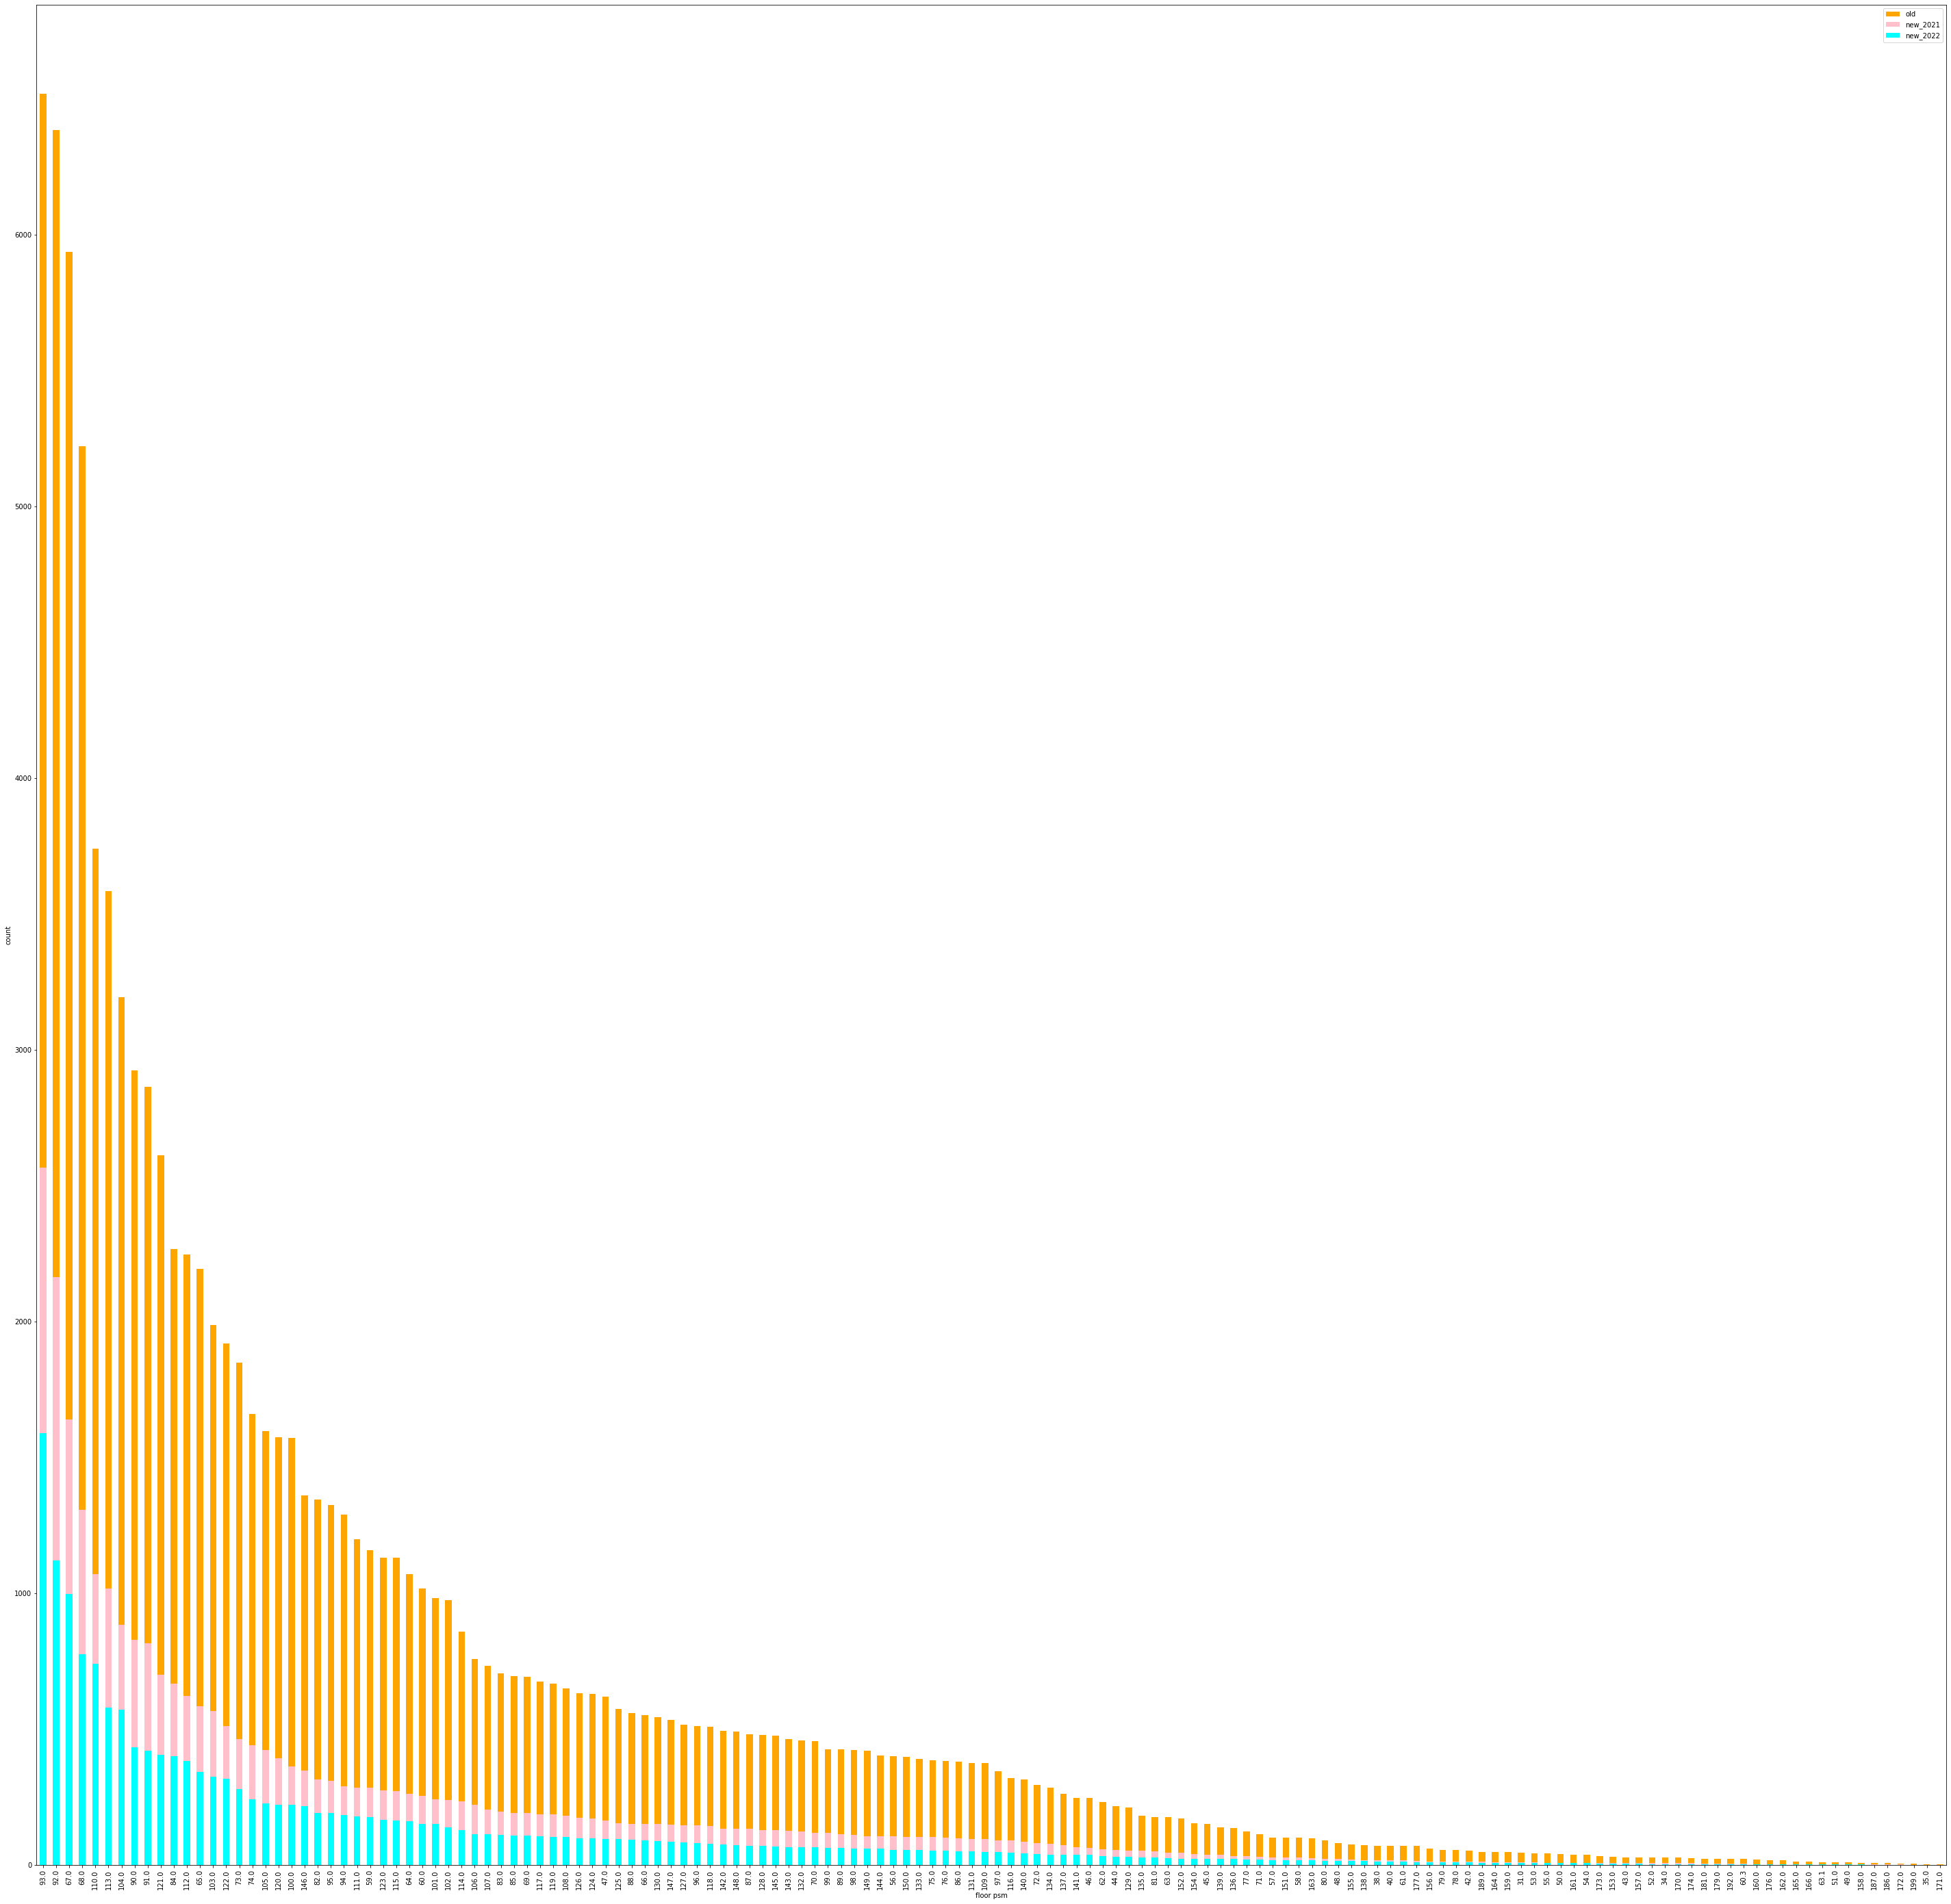

In [33]:
# floor psm feature

df_old["floor_area_sqm"].value_counts().plot.bar(color="orange")
df_new_21["floor_area_sqm"].value_counts().plot.bar(color="pink")
df_new_22["floor_area_sqm"].value_counts().plot.bar(color="cyan")

plt.legend(["old", "new_2021", "new_2022"])
plt.xlabel("floor psm")
plt.ylabel("count")

plt.rcParams["figure.figsize"] = (10,10)
plt.show()

A possible reason for covariate shift is the floor per square metre. In recent years the area of HDB's having been decreasing due to limited land space, and this causes a shift in the training data distribution of floor areas fed into the model which will led to model degradation.<br>
A suggestion to model degradation is to constantly retrain the model as new data is created.

In [34]:
train_dataframe_q3 = df[df['year'] < 2020]
val_dataframe_q3 = df[df['year'] == 2020]
train_dataframe_q3 = train_dataframe_q3.drop(columns=['year'])
train_dataframe_q3 = train_dataframe_q3.drop(columns=['full_address'])
train_dataframe_q3 = train_dataframe_q3.drop(columns=['nearest_stn'])
val_dataframe_q3 = val_dataframe_q3.drop(columns=['year'])
val_dataframe_q3 = val_dataframe_q3.drop(columns=['full_address'])
val_dataframe_q3 = val_dataframe_q3.drop(columns=['nearest_stn'])

train_ds_q3 = dataframe_to_dataset(train_dataframe_q3)
val_ds_q3 = dataframe_to_dataset(val_dataframe_q3)

train_ds_q3 = train_ds_q3.batch(256)
val_ds_q3 = val_ds_q3.batch(256)

# Q3d

In [39]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""

import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...

def embed_categorical_feature(feature, name, dataset, is_string, divisor=1):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    num_categories = lookup.vocabulary_size()
    embedded_feature = tf.keras.layers.Embedding(input_dim = num_categories+1, output_dim = math.floor(num_categories//divisor) )

    embedded_feature = embedded_feature(feature)
    embedded_feature = layers.Flatten()(embedded_feature)

    return embedded_feature

def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    month = keras.Input(shape=(1,), name="month", dtype="int64")

    # Categorical feature encoded as string
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

    # Categorical features encoded as integers
    month_embed = embed_categorical_feature(month, "month", train_ds_q3, False)

    # String categorical features
    flat_model_type_embed = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds_q3, True)
    storey_range_embed = embed_categorical_feature(storey_range, "storey_range", train_ds_q3, True)

    # Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds_q3)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds_q3)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds_q3)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds_q3)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds_q3)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds_q3)

    all_inputs = [
      dist_to_nearest_stn,
      dist_to_dhoby,
      degree_centrality,
      eigenvector_centrality,
      remaining_lease_years,
      floor_area_sqm,
      month,
      flat_model_type,
      storey_range
    ]

    all_features_input = [
        month_embed,
        flat_model_type_embed,
        storey_range_embed,
        remaining_lease_years_encoded,
        eigenvector_centrality_encoded,
        degree_centrality_encoded,
        dist_to_dhoby_encoded,
        dist_to_nearest_stn_encoded,
        floor_area_sqm_encoded
    ]
    
    
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history

    x = layers.Dense(16, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)

    model = keras.Model(all_inputs, output)
    
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.03622532209052661)
    model.compile(optimizer=adam_optimizer, loss='mse', metrics=[r2])

    history = model.fit(train_ds_q3, epochs=50, validation_data=val_ds_q3, batch_size=256, verbose='auto')
    
    val_loss_hx = history.history['val_loss'] # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)


vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), name='flatten_21/Reshape:0', description="created by layer 'flatten_21'")
KerasTensor(type_spec=TensorSpec(shape=(None, 42), dtype=tf.float32, name=None), name='flatten_22/Reshape:0', description="created by layer 'flatten_22'")
KerasTensor(type_spec=TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), name='flatten_23/Reshape:0', description="created by layer 'flatten_23'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_52/truediv:0', description="created by layer 'normalization_52'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_51/truediv:0', description="created by layer 'normalization_51'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dty

UnimplementedError:  Cast string to int32 is not supported
	 [[node model_10/embedding_22/Cast
 (defined at C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\layers\embeddings.py:190)
]] [Op:__inference_train_function_457699]

Errors may have originated from an input operation.
Input Source operations connected to node model_10/embedding_22/Cast:
In[0] model_10/ExpandDims_7 (defined at C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:655)

Operation defined at: (most recent call last)
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "c:\users\umer2\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\umer2\AppData\Local\Temp/ipykernel_27336/460860971.py", line 175, in <module>
>>>     loss = train_model(temp_vec)
>>> 
>>>   File "C:\Users\umer2\AppData\Local\Temp/ipykernel_27336/460860971.py", line 145, in train_model
>>>     history = model.fit(train_ds_q3, epochs=50, validation_data=val_ds_q3, batch_size=256, verbose='auto')
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\umer2\AppData\Roaming\Python\Python39\site-packages\keras\layers\embeddings.py", line 190, in call
>>>     inputs = tf.cast(inputs, 'int32')
>>> 

# Q3e

# Conclusion

In Q3, we witnessed what happened to machine learning models if they are not updated with the latest datasets and looked at whether covariate shift, label shift or concept drift has occurred. Which of these have led to model degradation? Was the change in LTV ratio the cause of it (if so, how did it affect the model performance)?<br>

Covariate shift has occured and led to model degradation. The shift in distribution in floor per square metre is an example of covariate shift, where the recent years saw a decrease in floor per square metre in HDB's, as compared to earlier years. As more data is fed in, the model's initial fit will become inaccurate as the actual outcome of resale price shifts in relation to the newer data, worsening the model's prediction. 

The change in LTV ratio makes little impact to the model's performance.